In [ ]:
### Need true spikes and predicted spikes;
### Angle of true vs. angle of predicted; 
### Need KG 
### Also need 

In [370]:
import pickle
import analysis_config
from dynamics_sims import plot_flow_field_utils
from online_analysis import generate_models
import math
%matplotlib notebook

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 11:24:00.853683. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



In [533]:
%load_ext autoreload
%autoreload 2

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 12:10:31.535224. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



In [178]:
dat = pickle.load(open(analysis_config.config['grom_pref'] + 'tuning_models_grom_model_set7_task_spec_pls_gen.pkl', 'rb'))

In [717]:
### Construct A matrix from model in dat; 
day =2; 
model_nm = 'hist_1pos_0psh_0spksm_1_spksp_0'
i_fold = 0; 
model = dat[day, model_nm, 10 + i_fold, 2, 'model']

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 12:46:19.754709. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



In [718]:
def model_2_Amat(mod):
    ''' Add intercept onto the end and bottom; '''
    A = np.hstack(( mod.coef_, mod.intercept_[:, np.newaxis] ))
    _, n = A.shape
    A = np.vstack((A, np.hstack(( np.zeros((n-1, )), [1] )) ))
    return A

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 12:46:20.070641. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



In [719]:
def kg_2_orth(KG_potent):
    _, n = KG_potent.shape
    KG_potent = np.vstack(( np.hstack((KG_potent, np.zeros((2, 1)))), np.hstack(( np.zeros((n)), [1]))))
    return KG_potent

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 12:46:20.302690. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



In [720]:
A = model_2_Amat(model)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 12:46:20.670324. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



In [721]:
KG_potent, KG_null_proj, KG_potent_orth = generate_models.get_KG_decoder_grom(day)
KG_potent = kg_2_orth(KG_potent)
U, S, Vh = scipy.linalg.svd(KG_potent); #[2x2, 2, 44x44]

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 12:46:21.054254. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



In [722]:
reconst = np.dot(U, np.dot(np.diag(S), Vh[:3, :]))
np.allclose(KG_potent, reconst)

True

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 12:46:22.118016. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



In [723]:
### Potent projection is Vh; 
assert(np.allclose(np.linalg.norm(Vh, axis=1), 1.))
assert(np.allclose(np.dot(Vh[0, :], Vh[1, :]), 0.))

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 12:46:22.646968. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



In [724]:
Neur2Vel = np.dot(U, Vh[:3, :])
KGA = np.dot(Neur2Vel, np.dot(A, Neur2Vel.T))

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 12:46:23.278334. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



<IPython.core.display.Javascript object>


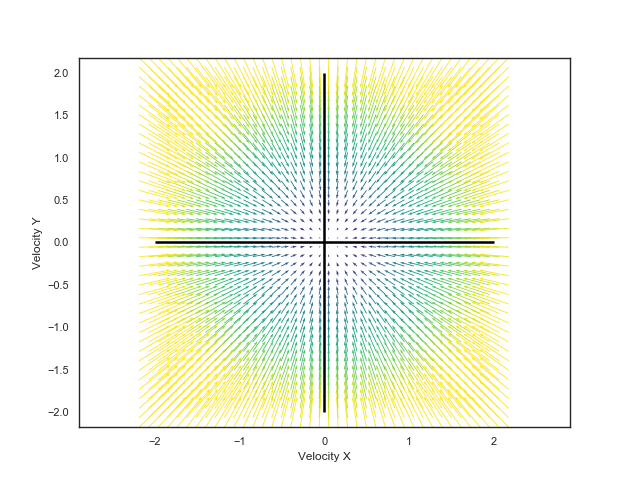

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 12:46:24.147635. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



In [725]:
f, ax = plt.subplots()
ax.axis('equal')
lims = 2; 
plot_flow_field_utils.plot_flow(KGA, ax, cmax = 2., scale = 5.5, 
                                width = .01, xmin=-lims, xmax=lims, ymin=-lims,
                               ymax = lims, dim0=0, dim1=1, nb_points = 40, setdimeq1 = True)
ax.set_xlabel('Velocity X')
ax.set_ylabel('Velocity Y')
ax.vlines(0, -lims, lims, 'k')
ax.hlines(0, -lims, lims, 'k')

In [530]:
ev, evc = np.linalg.eig(KGA)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 12:07:06.157987. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



In [531]:
evc

array([[ 0.        ,  0.        ,  0.91106829],
       [ 0.52685223, -0.92088178, -0.1624633 ],
       [-0.8499569 ,  0.38984196, -0.37889345]])

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 12:07:07.235168. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



(2, 45)

In [112]:
true_spks = dat[(day, 'spks')]

### General model 
pred_spks = dat[(day, 'hist_1pos_0psh_0spksm_1_spksp_0')][:, :, 2]

In [147]:
true_KG = np.dot(KG, true_spks.T).T
pred_KG = np.dot(KG, pred_spks.T).T

In [148]:
ang_true_KG = np.hstack(([math.atan2(true_KG[i, 5], true_KG[i, 3]) for i in range(len(true_KG))]))
ang_pred_KG = np.hstack(([math.atan2(pred_KG[i, 5], pred_KG[i, 3]) for i in range(len(pred_KG))]))

ang_true_KG[ang_true_KG < 0] += 2*np.pi
ang_pred_KG[ang_pred_KG < 0] += 2*np.pi

In [149]:
# t = np.linspace(0, 2*np.pi, 1000)
# x = np.cos(t)
# y = np.sin(t)
# a = np.hstack(([math.atan2(y[i], x[i]) for i in range(1000)]))
# a[a < 0] += 2*np.pi
# f, ax = plt.subplots()
# plt.plot(t, a)

<IPython.core.display.Javascript object>


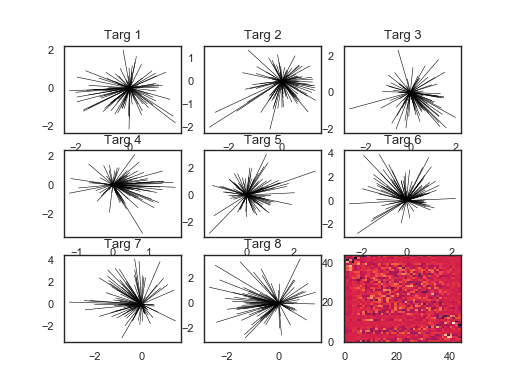

In [161]:
### For each target, plot the angle diffs ####
trg = dat[(day, 'trg')]
f, ax = plt.subplots(ncols = 3, nrows = 3)
for i in range(8):
    trg_ix = np.nonzero(trg == i)[0]
    for ti in trg_ix[:100]:
        ax[i/3, i%3].plot([0, true_KG[ti, 3] - pred_KG[ti, 3]], [0, true_KG[ti, 5] - pred_KG[ti, 5]], 'k-',
                         linewidth=.5)
    ax[i/3, i%3].set_title('Targ %d' %(i+1))
    #ax[i/3, i%3].hlines(np.mod(np.linspace(np.pi, 3*np.pi, 9)[1:][i], 2*np.pi), 0, 2*np.pi, 'r')

In [159]:
true_KG[ti, 3] - pred_KG[ti, 3]

-1.1717552164586473

In [116]:
### PCA on true velocity vs. predicted velocities; ####
cov_KG_true = np.cov(true_KG[:, [3, 5]].T)
cov_KG_pred = np.cov(pred_KG[:, [3, 5]].T)

In [117]:
def pca(X):
    ev, evect = np.linalg.eig(X)
    
    ix_sort = np.argsort(np.abs(ev))
    return ev[ix_sort[::-1]], evect[:, ix_sort[::-1]]

In [118]:
evtrue, pc_true = pca(cov_KG_true)
evpred, pc_pred = pca(cov_KG_pred)

#evtrue = evtrue/np.sum(evtrue)
#evpred = evpred/np.sum(evpred)

In [119]:
evtrue

array([1.82951645, 1.35739143])

In [120]:
evpred

array([0.70111904, 0.5071964 ])

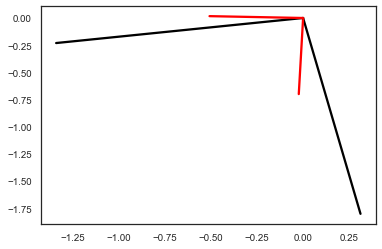

In [121]:
for i in range(2):
    plt.plot([0, evtrue[i]*pc_true[0, i]], [0, evtrue[i]*pc_true[1, i]], 'k-')
    plt.plot([0, evpred[i]*pc_pred[0, i]], [0, evpred[i]*pc_pred[1, i]], 'r-')